# [kaggleのタイタニック]

- カーネルを参考に一旦最後まで解析を実施

## 1. 入力

 ### 1.1 必要なライブラリなどをインポートする

In [42]:
import pandas as pd 
import numpy as np

import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

from collections import Counter

import re

# jupyter-notebookに描画する
%matplotlib inline

### 1.2 入力データを読み込む

In [43]:
# csvを読み込み、文字の変換を行う
titanic_df= pd.read_csv("./input/train.csv")

test_df= pd.read_csv("./input/test.csv")
IDtest = test_df["PassengerId"]

titanic_df.info()
titanic_df.head()
titanic_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 1.3 one-hot エンコーディング

In [44]:
# Sexを値に置換
titanic_df['Sex'] =titanic_df['Sex'].replace('male',1).replace('female',2)
test_df['Sex'] =test_df['Sex'].replace('male',1).replace('female',2)

# Embarkedにを値に置換
titanic_df['Embarked']=titanic_df['Embarked'].replace('S',1).replace('C',2).replace('Q',3)
test_df['Embarked']=test_df['Embarked'].replace('S',1).replace('C',2).replace('Q',3)

titanic_df['Embarked']=titanic_df['Embarked'].fillna(1)



## 2. 外れ値の検討

### 2.1 外れ値の有無を検討する
- PassengerId〜Sex、Ticket, Cabin, Embarkedについては、項目の特性上「外れ値」にはならないと想定したため、Age, SibSp, Parch Fareについて外れ値を検討

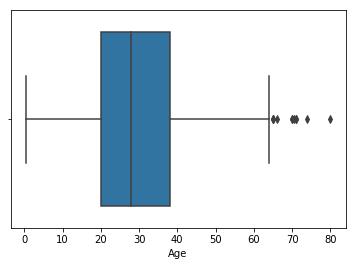

In [45]:
'''
[Age]
 箱ひげ図とカーネル密度推定からすると外れ値にしても良さそうなものがある
'''
sns.boxplot('Age',data=titanic_df)


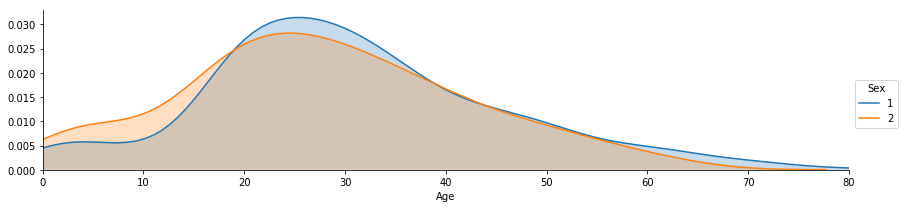

In [46]:
fig = sns.FacetGrid(titanic_df,hue='Sex', aspect=4)
fig.map(sns.kdeplot, 'Age', shade=True)
oldest = titanic_df['Age'].max()
fig.set(xlim=(0,oldest))
fig.add_legend()

,PassengerId,Survived,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked
SibSp,,,,,,,,,,,
0,608,608,608,608,608,471,608,608,608,126,608
1,209,209,209,209,209,183,209,209,209,69,209
2,28,28,28,28,28,25,28,28,28,6,28
3,16,16,16,16,16,12,16,16,16,3,16
4,18,18,18,18,18,18,18,18,18,0,18
5,5,5,5,5,5,5,5,5,5,0,5
8,7,7,7,7,7,0,7,7,7,0,7


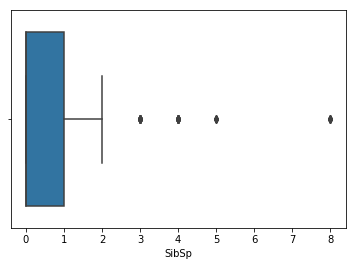

In [47]:
'''
[SibSp]
 箱ひげ図と実際のデータからすると外れ値と考える事は難しそう。
'''
sns.boxplot('SibSp',data=titanic_df)

titanic_df.groupby('SibSp').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Embarked
Parch,,,,,,,,,,,
0,678,678,678,678,678,521,678,678,678,141,678
1,118,118,118,118,118,110,118,118,118,39,118
2,80,80,80,80,80,68,80,80,80,23,80
3,5,5,5,5,5,5,5,5,5,0,5
4,4,4,4,4,4,4,4,4,4,1,4
5,5,5,5,5,5,5,5,5,5,0,5
6,1,1,1,1,1,1,1,1,1,0,1


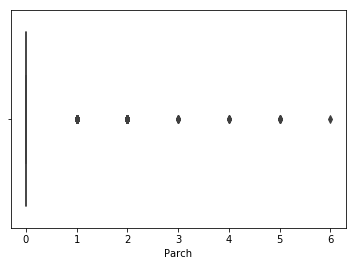

In [48]:
'''
[Parch]
 箱ひげ図と実際のデータからすると外れ値と考える事は難しそう。
'''
sns.boxplot('Parch',data=titanic_df)

titanic_df.groupby('Parch').count()

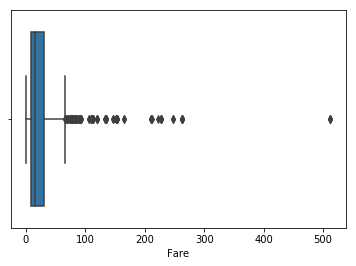

In [49]:
'''
[Fare]
 500以上の料金を払った人が外れ値として考えて良さそう。ただ、箱ひげ図で除外するのは止めたほうが良さそう
'''
sns.boxplot('Fare',data=titanic_df)

### 2.2 検討した結果を元に外れ値を削除する

In [50]:
'''
 Yassine Ghouzamさんが作成したノートブックを参考に[Age]を削除
'''

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        # Q1 = np.percentile(df[col], 25)
        Q1 = df[col].describe()['25%']
        # 3rd quartile (75%)
        #Q3 = np.percentile(df[col],75)
        Q3 = df[col].describe()['75%']
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
               
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(titanic_df,0,["Age"])

titanic_df.loc[Outliers_to_drop] # Show the outliers rows

titanic_df = titanic_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 3. 欠損値の対処

### 3.1 欠損に対処

In [51]:
# 解析するためにtestデータもくっつける
vtrain_len = len(titanic_df)
dataset_df =  pd.concat(objs=[titanic_df, test_df], axis=0).reset_index(drop=True)

# 後ほど復元するためにサイズを保存
titanic_len = len(titanic_df)

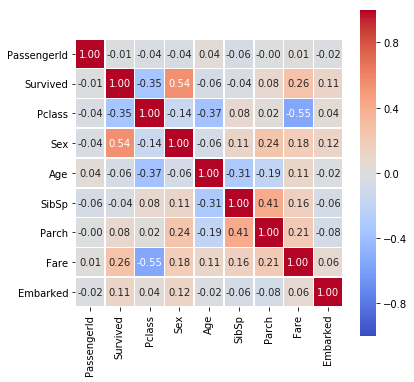

In [52]:
corrmat = titanic_df.corr()
plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, vmax=1,vmin=-1, square=True, annot=True, fmt='1.2f',linewidths=.5,cmap='coolwarm',center=0)

In [53]:
# Age
# Ageが欠損しているデータについて、SibSP, Parch, Pclassが等しいデータを探して平均値をとる

index_NaN_age = list(dataset_df["Age"][dataset_df["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset_df["Age"].median()
    age_pred = dataset_df["Age"][((dataset_df['SibSp'] == dataset_df.iloc[i]["SibSp"]) & (dataset_df['Parch'] == dataset_df.iloc[i]["Parch"]) & (dataset_df['Pclass'] == dataset_df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset_df['Age'].iloc[i] = age_pred
    else :
        dataset_df['Age'].iloc[i] = age_med


/home/hide/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
# Nameに入っている　「Mr.」等を Salutation列を作って入れる

Title=pd.DataFrame([i.split(', ')[1].split('.')[0] for i in dataset_df['Name']])

dataset_df['Title'] = Title

dataset_df.head()

combine =[dataset_df]

Title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4} 
for dataset_df in combine:
        dataset_df['Title'] = dataset_df['Title'].map(Title_mapping) 
        dataset_df['Title'] = dataset_df['Title'].fillna(0)

dataset_df.drop(labels = ["Name"], axis = 1, inplace = True)

In [55]:
dataset_df.drop(labels = ["Ticket"], axis = 1, inplace = True)
dataset_df.drop(labels = ["Cabin"], axis = 1, inplace = True)

In [56]:
# NULL値を補正
dataset_df['Fare'].fillna(dataset_df.Pclass.median(),inplace=True)

In [57]:
# Apply log to Fare to reduce skewness distribution
#dataset_df["Fare"] = dataset_df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [58]:
combine=[dataset_df]
dataset_df["FamilySize"] = dataset_df["SibSp"] + dataset_df["Parch"] + 1
for dataset_df in combine:
    dataset_df['IsAlone'] = 0
    dataset_df.loc[dataset_df['FamilySize'] == 1, 'IsAlone'] = 1

In [59]:
titanic_df=dataset_df[:titanic_len]
test_df=dataset_df[titanic_len:]
test_df.drop(labels=["Survived"],axis = 1,inplace=True)

titanic_df["Survived"] = titanic_df["Survived"].astype(int)

Y_train = titanic_df["Survived"]

X_train = titanic_df.drop(labels = ["Survived"],axis = 1)


/home/hide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,RandomizedSearchCV


# トレーニングデータと訓練データに分ける
kfold = StratifiedKFold(n_splits=10)

In [ ]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(xgb.XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","Xgbooxt"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [ ]:
# ランダムフォレスト用のパラメータをグリッドサーチ
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [22]:
# ランダムフォレスト用のパラメータをランダムサーチ
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid =  {'max_depth'          : [None],
                  'max_features'       : [1, 3, 10],
                  'min_samples_split'  : [2, 3, 10],
                  'min_samples_leaf'   : [1, 3, 10],
                  'bootstrap'          : [False],
                  'n_estimators'       : [100,200,300],
                  'criterion'          : ["gini"]}

rsRFC = RandomizedSearchCV(RFC,param_distributions = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

rsRFC.fit(X_train,Y_train)

RFC_best = rsRFC.best_estimator_

# Best score
rsRFC.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   52.4s finished


best: 0.8363636363636363
param: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


In [23]:
# EXTree 
ET = ExtraTreesClassifier()

## Search grid for optimal parameters
ET_param_grid = {'criterion'          : ['gini'],
                 'max_features'       : [1, 3, 10],
                 'max_depth'          : [None],
                 'min_samples_split'  : [2, 3, 10],
                 'min_samples_leaf'   : [1, 3, 10],
                 'bootstrap'          : [False],
                 'n_estimators'       : [100,300]}

gsET = GridSearchCV(ET,param_grid = ET_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsET.fit(X_train,Y_train)

ET_best = gsET.best_estimator_

# Best score
gsET.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  3.9min finished


0.8318181818181818

In [24]:
#LogisticRegression
LR = LogisticRegression()

## Search grid for optimal parameters
LR_param_grid = {'max_iter'           : [10,100,200],
                 'verbose'            : [0, 1, 10],
                 'n_jobs'             : [1, 5, 10],
                 'dual'               : [True, False]}

gsLR = GridSearchCV(LR,param_grid = LR_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,Y_train)

LR_best = gsLR.best_estimator_

# Best score
gsLR.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Li

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs'

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have 

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not hav

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, in

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarn

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, in

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarn

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have 

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not hav

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarn

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: User

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserW

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   19.9s finished


0.8181818181818182

In [25]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss'            : ["deviance"],
                 'n_estimators'    : [100,200,300],
                 'learning_rate'   : [0.1, 0.05, 0.01],
                 'max_depth'       : [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features'    : [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.8min finished


best: 0.8227272727272728
param: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.1, 'min_samples_leaf': 100, 'n_estimators': 300}


In [26]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss'            : ["deviance"],
                 'n_estimators'    : [100,200,300],
                 'learning_rate'   : [0.1, 0.05, 0.01],
                 'max_depth'       : [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features'    : [0.3, 0.1] 
              }
rsGBC = RandomizedSearchCV(GBC,param_distributions = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

rsGBC.fit(X_train,Y_train)

GBC_best = rsGBC.best_estimator_

# Best score
rsGBC.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   15.5s finished


best: 0.8204545454545454
param: {'n_estimators': 100, 'min_samples_leaf': 100, 'max_features': 0.3, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.1}


In [35]:

XGBx = xgb.XGBClassifier()

param         = {'n_estimators'    : [100,200,300],
                 'learning_rate'   : [0.1, 0.05, 0.01],
                 'max_depth'       : [1,4, 8],
                 'min_child_weight': [1,5,10]
              }

gsXGB = RandomizedSearchCV(XGBx,param_distributions = param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train,Y_train)

XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

0.8329545454545455

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

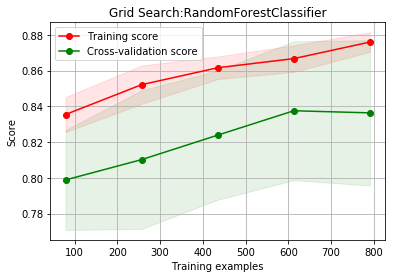

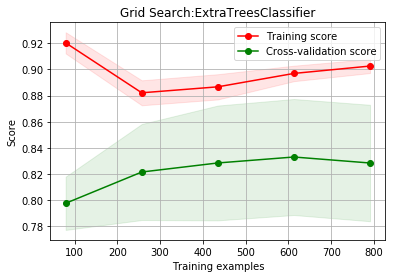

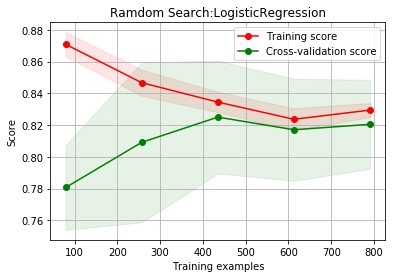

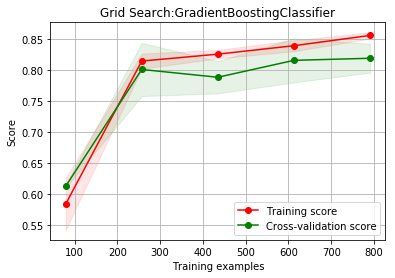

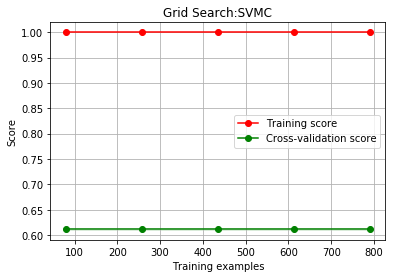

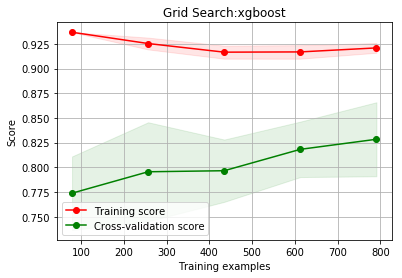

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"Grid Search:RandomForestClassifier",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsET.best_estimator_,"Grid Search:ExtraTreesClassifier",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"Ramdom Search:LogisticRegression",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"Grid Search:GradientBoostingClassifier",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"Grid Search:SVMC",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsXGB.best_estimator_,"Grid Search:xgboost",X_train,Y_train,cv=kfold)

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


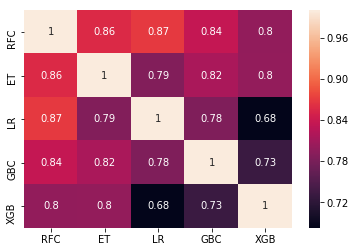

In [37]:
test_Survived_RFC = pd.Series(gsRFC.best_estimator_.predict(test_df), name="RFC")
test_Survived_ET = pd.Series(gsET.best_estimator_.predict(test_df), name="ET")
test_Survived_LR = pd.Series(gsLR.best_estimator_.predict(test_df), name="LR")
test_Survived_GBC = pd.Series(gsGBC.best_estimator_.predict(test_df), name="GBC")
test_Survived_XGB = pd.Series(gsXGB.best_estimator_.predict(test_df), name="XGB")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ET,test_Survived_LR,test_Survived_GBC,test_Survived_XGB],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [38]:
votingC = VotingClassifier(estimators=[('rfc', gsRFC.best_estimator_), ('et', gsET.best_estimator_),
('lr', gsLR.best_estimator_), ('gbc',gsGBC.best_estimator_),('xgb',gsXGB.best_estimator_)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [40]:
test_Survived = pd.Series(votingC.predict(test_df), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)


/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
